In [1]:
import numpy as np
import pandas as pd
import teamwork_visualisation as tv
import warnings
warnings.simplefilter("default")
import os
import datetime
import seaborn as sns

c:\users\danny\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Manual parameter setting

In [2]:
input_file_name = './data/audio_data.txt' 

In [3]:
## Use MIT routines to get an aligned dataframe of samples

audio_data = tv.pre_processing.raw_rhythm_to_aligned_df(input_file_name)

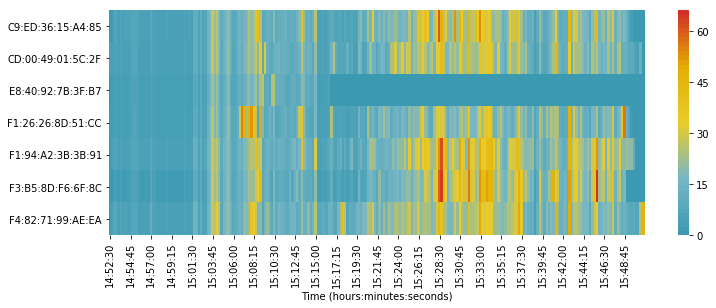

In [4]:
## Plot the raw volume over time 

tv.plotting_functions.plot_raw_volume(audio_data)

### Time zone

In [5]:
## Set to the correct time zone
time_zone = "CET"

try:
    audio_data.index = audio_data.index.tz_localize("GMT").tz_convert(time_zone)
    
except TypeError as err:
    
    if err.args[0] == "Already tz-aware, use tz_convert to convert.":        
        raise ValueError("Time zone has already been set. Please re-load the Rhythm data if a different time zone is needed.")
    
    else:        
        raise err

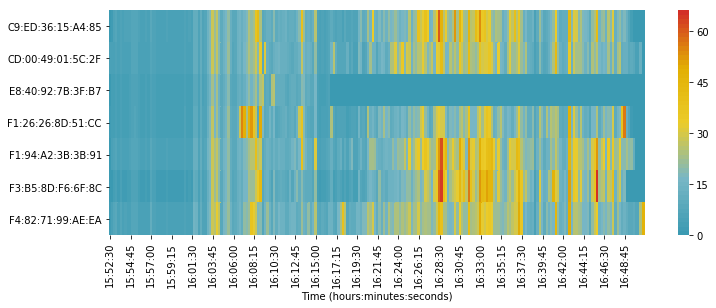

In [6]:
## Plot the raw volume over time again

tv.plotting_functions.plot_raw_volume(audio_data)

### Custom starting and/or ending point

In [7]:
## For a custom starting point, provide the datetime
start_point = "2020-01-13 16:09:00"

## A custom end point can also be provided
end_point = None

In [8]:
## Compare start and end

if start_point and end_point:    
    if pd.to_datetime(start_point).tz_localize(time_zone) > pd.to_datetime(end_point).tz_localize(time_zone):
        raise ValueError("Custom start point is after custom end point.")

## Start from the custom point

if start_point:
    
    if audio_data.index.max() < pd.to_datetime(start_point).tz_localize(time_zone):
        raise ValueError("Start point is after the audio data finishes.")
    
    audio_data = audio_data.loc[audio_data.index > pd.to_datetime(start_point).tz_localize(time_zone)]

## End at the custom point

if end_point:
    
    if audio_data.index.min() > pd.to_datetime(end_point).tz_localize(time_zone):
        raise ValueError("End point is before the audio data starts.")
    
    audio_data = audio_data.loc[audio_data.index < pd.to_datetime(end_point).tz_localize(time_zone)]

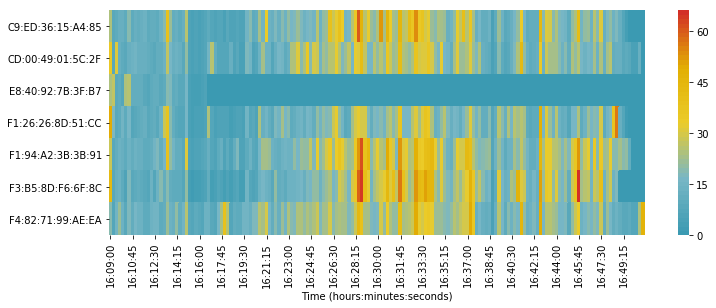

In [9]:
## Plot the raw volume over time again

tv.plotting_functions.plot_raw_volume(audio_data)

### Edit labels for the participants

In [10]:
## Custom labels for the participants

## Show the default labels
print(audio_data.columns)

Index(['C9:ED:36:15:A4:85', 'CD:00:49:01:5C:2F', 'E8:40:92:7B:3F:B7',
       'F1:26:26:8D:51:CC', 'F1:94:A2:3B:3B:91', 'F3:B5:8D:F6:6F:8C',
       'F4:82:71:99:AE:EA'],
      dtype='object', name='member')


In [11]:
## Define new ones; set new_column_names to None if you wish to use the defaults or 
## wish to use an Excel spreadsheet to provide new names
#new_column_names = None
new_column_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [12]:
## Define new names in an Excel spreadsheet; set badge_labels to None if you do not want to do this
badge_labels_file = None
#badge_labels_file = "./badge_labels.xlsx"

In [13]:
if new_column_names:
    
    ## Rename columns
    audio_data = audio_data.rename(columns=dict(zip(audio_data.columns, new_column_names)))
    
elif badge_labels_file:
    
    with warnings.catch_warnings():
        
        warnings.simplefilter("ignore")

        try:
            ## Rename columns
            badge_labels = pd.read_excel(badge_labels_file)
            audio_data = audio_data.rename(columns=dict(zip(badge_labels.badge, badge_labels.label)), errors="raise")

        except KeyError as err:
            raise ValueError("The following badge names could not be found: " + err.args[0][:-18])


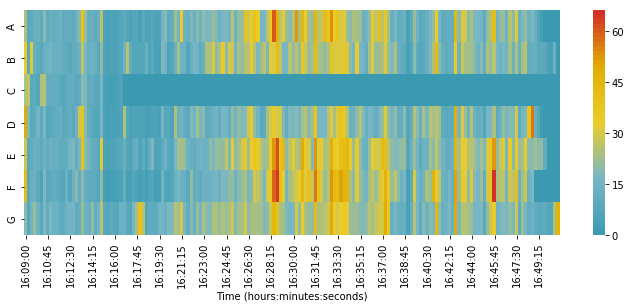

In [14]:
## Plot the raw volume over time again

tv.plotting_functions.plot_raw_volume(audio_data)

### Remove participants

In [15]:
## Removing participants if desired
## Be careful - these participants will not appear in any of the visualisations

participants_to_remove = None
#participants_to_remove = ["C"]

if participants_to_remove:
    
    try:
        audio_data = audio_data.drop(columns=participants_to_remove)
        
    except KeyError as err:
        raise ValueError("The following participants_to_remove could not be found: " + err.args[0][:-18])

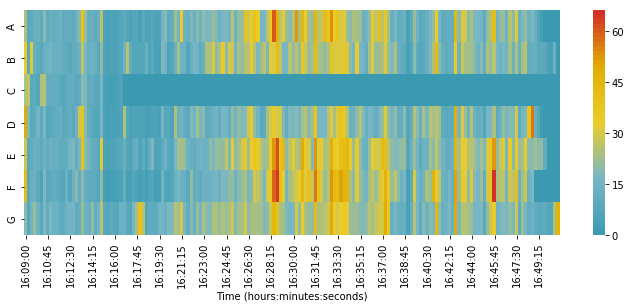

In [16]:
## Plot the raw volume over time again

tv.plotting_functions.plot_raw_volume(audio_data)

### Define 'key points'

In [17]:
use_key_point_labels = True

key_points = {
     "2020-01-13 16:13:55" : "Start individual ranking",
     "2020-01-13 16:19:05" : "Start video",
     "2020-01-13 16:22:22" : "Start team ranking",
     "2020-01-13 16:37:20" : "Start post-task"
}

if key_points:

    key_points = pd.Series(list(key_points.values()),
                              index=pd.to_datetime(list(key_points.keys())).tz_localize(time_zone),
                             name="key_points")

    if key_points.duplicated().any() and use_key_point_labels:

        raise ValueError("Please edit or remove duplicate labels in key_points")

    ## Should not be needed since Pandas will ignore duplicated indices, but included for safety
    if key_points.index.duplicated().any() and use_key_point_labels is not True:

        raise ValueError("Please edit or remove duplicate times in key_points")
    

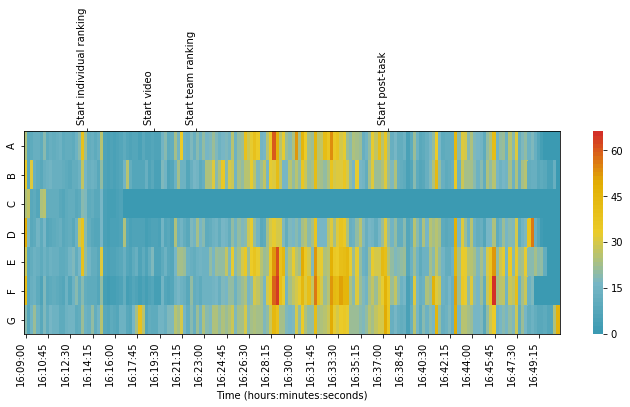

In [18]:
## Plot the raw volume over time again

tv.plotting_functions.plot_raw_volume(audio_data, key_points=key_points, use_key_point_labels=use_key_point_labels)

### Relative scaling

In [19]:
## It is unlikely that this will need to be changed

## Switch this off if you don't want the sizes of nodes and edges to adapt to the dataset

## The only reason you might want to do this is if you want to make a tentative comparison between two files of recordings
## But beware - the comparison is still unreliable due to possible differences in VAD and the recording conditions, 
## which both are likely to affect energy and engagement scores

relative_scaling = True

# Data pre-processing

### Correlation threshold

In [20]:
## Try to find a sensible correlation threshold

correlation_threshold = tv.pre_processing.get_correlation_threshold_recommendation(audio_data)

print(correlation_threshold)

0.3


### Opportunity to override correlation threshold

In [21]:
## You can manually override this if you want to and set it to your preference
correlation_threshold = correlation_threshold

print(correlation_threshold)

0.3


## VAD

In [22]:
speak_real = tv.pre_processing.voice_activity_detection(audio_data, correlation_threshold)

### Find per-second speech

In [23]:
per_second_speech = tv.pre_processing.get_per_second_speech(speak_real)

# Create output folder

In [24]:
folder_name = os.path.splitext(os.path.basename(input_file_name))[0] + datetime.datetime.now().strftime("__%Y_%m_%d__%H_%M_%S")

output_folder = os.path.join(".",folder_name)

os.makedirs(output_folder)

In [25]:
## Saves the parameter settings

parameter_dict = {
    "time_zone" : time_zone,
    "start_point" : start_point,
    "end_point" : end_point,
    "correlation_threshold" : "{:.2f}".format(correlation_threshold),
    "participants_to_remove" : participants_to_remove,
    "use_key_point_labels" : use_key_point_labels
}

with open(os.path.join(output_folder, "parameters.txt"), "w") as parameter_file:
    
    parameter_file.write(str(parameter_dict))

# Extract critical instabilities

In [26]:
dynamic_complexity_results = tv.dynamic_complexity.get_dynamic_complexity_audio(audio_data)

In [27]:
critical_instabilities = tv.dynamic_complexity.get_critical_instabilities(dynamic_complexity_results)

# Create visualisations

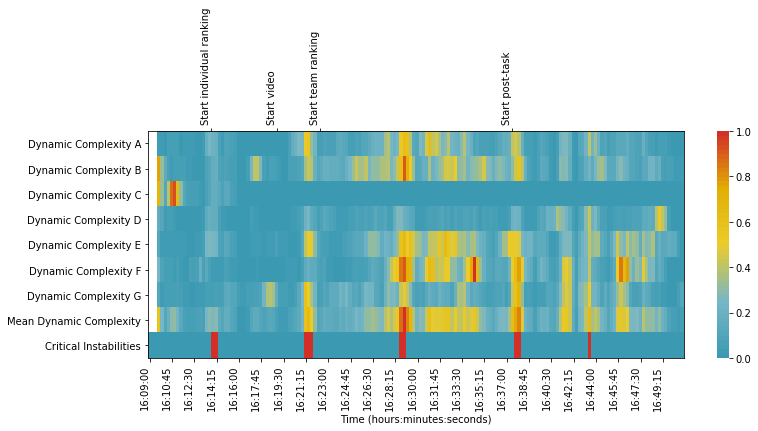

In [28]:
tv.plotting_functions.plot_dynamic_complexity(dynamic_complexity_results, 
                                              critical_instabilities, 
                                              key_points=key_points, 
                                              output_folder=output_folder)

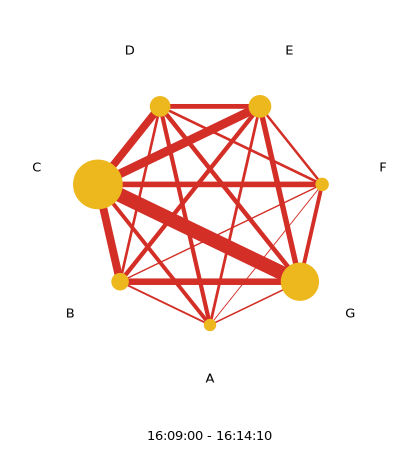

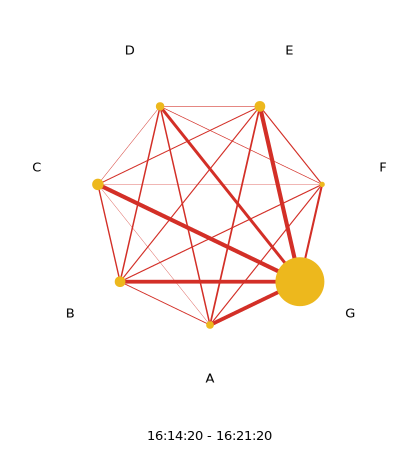

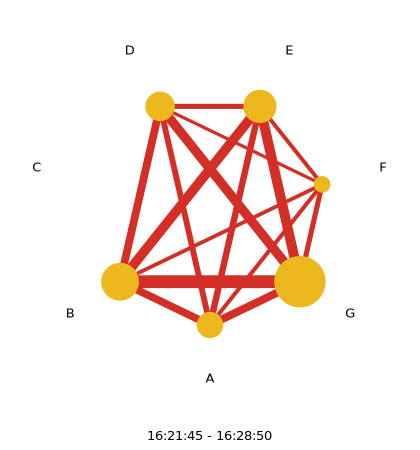

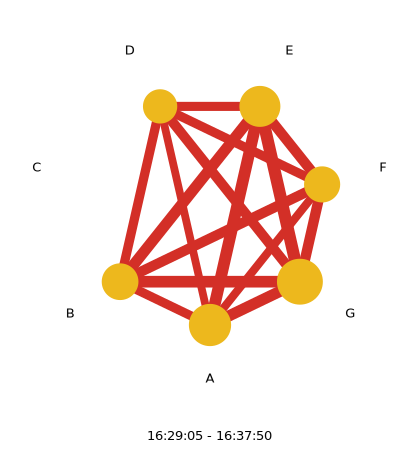

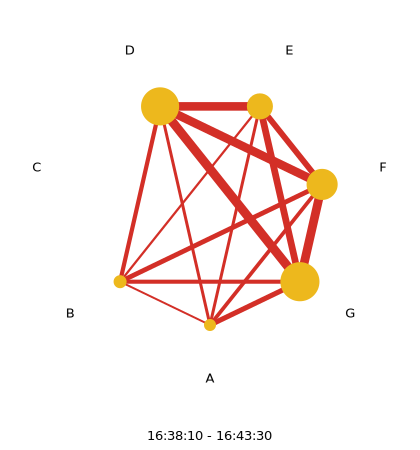

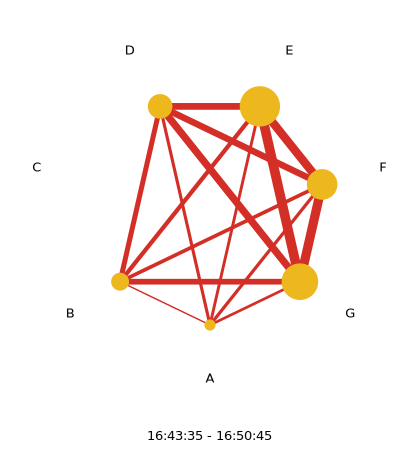

In [29]:
tv.plotting_functions.plot_network_visualisations(critical_instabilities, 
                                                  per_second_speech, 
                                                  output_folder=output_folder, 
                                                  time_zone=time_zone,
                                                  relative_scaling=relative_scaling
                                                 )

### Network visualisation overall for the data set

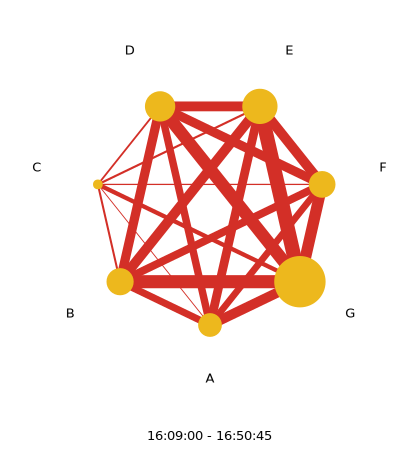

In [30]:
tv.plotting_functions.plot_network_overall(critical_instabilities, 
                                                  per_second_speech, 
                                                  output_folder=output_folder, 
                                                  time_zone=time_zone,
                                                  relative_scaling=relative_scaling
                                                 )

### Visualise a custom slice of data

In [36]:
## Remember that the calculations won't be very reliable or it might not even be possible to visualise the data if the 
## slice is too short. It is best to use five minutes or more of data. 
slice_start = "2020-01-13 16:15:00"
slice_end = "2020-01-13 16:25:00"

In [37]:
## Compare start and end

if slice_start and slice_end:    
    if pd.to_datetime(slice_start).tz_localize(time_zone) > pd.to_datetime(slice_end).tz_localize(time_zone):
        raise ValueError("Custom start point is after custom end point.")

## Start from the custom point

if slice_start:
    
    if critical_instabilities.index.max() < pd.to_datetime(slice_start).tz_localize(time_zone):
        raise ValueError("Start point is after the audio data finishes.")

## End at the custom point

if slice_end:
    
    if critical_instabilities.index.min() > pd.to_datetime(slice_end).tz_localize(time_zone):
        raise ValueError("End point is before the audio data starts.")

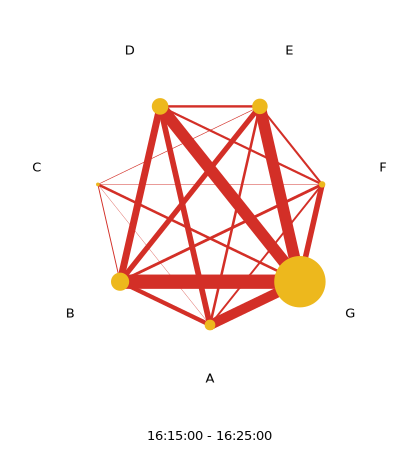

In [38]:
## This works, but the code is a bit ugly, so should be cleaned up when the chance occurs. 
slice_indices = critical_instabilities[slice_start:slice_end] & False
tv.plotting_functions.plot_network_visualisations(slice_indices, 
                                                  per_second_speech, 
                                                  output_folder=output_folder, 
                                                  time_zone=time_zone,
                                                  relative_scaling=relative_scaling
                                                 )